#Supervised Contrastive Learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Implementation by G. M. Shahariar Shibli

#Version and GPU check

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
!nvidia-smi

Thu Mar 23 06:15:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Installation

In [ ]:
%%capture
!pip3 install tensorflow-addons
!pip3 install tf_keras_vis

#Imports

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import datetime
import glob
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

#Configurations

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (224, 224, 3)

LR = 2e-5
shuffler = 1024

#Data Augmentation

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image, label

# Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cecum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/cecum/*.*')
ileum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ileum/*.*')
retroflex_rectum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum/*.*')
hemorrhoids = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids/*.*')
polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/polyps/*.*')
ulcerative_colitis_grade_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1/*.*')
ulcerative_colitis_grade_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1/*.*')
ulcerative_colitis_grade_1_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2/*.*')
ulcerative_colitis_grade_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2/*.*')
ulcerative_colitis_grade_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3/*.*')
ulcerative_colitis_grade_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3/*.*')
bbps_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1/*.*')
bbps_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3/*.*')
impacted_stool = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool/*.*')
dyed_lifted_polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps/*.*')
dyed_resection_margins = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins/*.*')
pylorus = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/pylorus/*.*')
retroflex_stomach = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach/*.*')
z_line = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/z_line/*.*')
barretts = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts/*.*')
barretts_short_segment = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment/*.*')
esophagitis_a = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a/*.*')
esophagitis_b_d = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d/*.*')

In [ ]:
dataset = {0 :cecum, 1:ileum, 2:retroflex_rectum, 3:hemorrhoids, 4:polyps,5:ulcerative_colitis_grade_0_1,6:ulcerative_colitis_grade_1,7:ulcerative_colitis_grade_1_2,8:ulcerative_colitis_grade_2,9:ulcerative_colitis_grade_2_3,10:ulcerative_colitis_grade_3,11:bbps_0_1 ,12:bbps_2_3,13:impacted_stool,14:dyed_lifted_polyps,15:dyed_resection_margins,16:pylorus,17:retroflex_stomach,18:z_line,19:barretts,20:barretts_short_segment,21:esophagitis_a ,22:esophagitis_b_d }

In [ ]:
def combineDataAndLabel(width, height, dataset):

  data = []
  labels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
          target_size= (width,height))
          image=np.array(image)
          data.append(image)
          count=count+1
          labels.append(cls)
      print(f"\n\processed {count} images \n\n")


  # for i in cecum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(0)

  # for i in ileum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(1)
  # for i in pylorus:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(2)
  # for i in retroflex_rectum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(3)
  # for i in retroflex_stomach:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(4)
  # for i in z_line:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(5)

  data = np.array(data)
  labels = np.array(labels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ML/combinedData_224', data)
  np.save('/content/drive/MyDrive/ML/combinedLabels_224', labels)
  print(f"\n\nSaved")

  return data, labels


In [ ]:
import os
data = []
labels = []
if(os.path.isfile("/content/drive/MyDrive/ML/combinedData_224.npy") and os.path.isfile("/content/drive/MyDrive/ML/combinedLabels_224.npy")):
  data = np.load("/content/drive/MyDrive/ML/combinedData_224.npy")
  labels = np.load("/content/drive/MyDrive/ML/combinedLabels_224.npy")
else:
  data, labels = combineDataAndLabel(224,224,dataset)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42,stratify = labels)

In [ ]:
# Load data
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (8529, 224, 224, 3) - y_train shape: (8529,)
x_test shape: (2133, 224, 224, 3) - y_test shape: (2133,)


In [ ]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).map(custom_augment).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

#Contrastive Loss Functions

Max Margin Loss, N pairs loss, Triplet loss, NT-XENT loss

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss.
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from:
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

#Encoder with Contrastive Learning

In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

100%|██████████| 134/134 [02:52<00:00,  1.29s/it]


Epoch 1, Training Loss: 0.08236506581306458, Test Loss: 0.9165855050086975


100%|██████████| 134/134 [01:36<00:00,  1.39it/s]


Epoch 2, Training Loss: 0.07709892839193344, Test Loss: 0.8624257445335388


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 3, Training Loss: 0.0763455256819725, Test Loss: 0.6407353281974792


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 4, Training Loss: 0.07521526515483856, Test Loss: 0.20096245408058167


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 5, Training Loss: 0.07430174946784973, Test Loss: 0.093907430768013


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 6, Training Loss: 0.07259578257799149, Test Loss: 0.08230134099721909


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 7, Training Loss: 0.07130539417266846, Test Loss: 0.07752200216054916


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 8, Training Loss: 0.06974155455827713, Test Loss: 0.07671671360731125


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 9, Training Loss: 0.07004222273826599, Test Loss: 0.07428990304470062


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 10, Training Loss: 0.06805800646543503, Test Loss: 0.0735817477107048


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 11, Training Loss: 0.06857297569513321, Test Loss: 0.07406403869390488


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 12, Training Loss: 0.06774815917015076, Test Loss: 0.0733223631978035


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 13, Training Loss: 0.06598366051912308, Test Loss: 0.07142506539821625


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 14, Training Loss: 0.06648280471563339, Test Loss: 0.07002916187047958


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 15, Training Loss: 0.06687811017036438, Test Loss: 0.06966588646173477


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 16, Training Loss: 0.06593794375658035, Test Loss: 0.06933820247650146


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 17, Training Loss: 0.0654941201210022, Test Loss: 0.06672689318656921


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 18, Training Loss: 0.06588422507047653, Test Loss: 0.06686434894800186


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 19, Training Loss: 0.06540845334529877, Test Loss: 0.06773389130830765


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 20, Training Loss: 0.0635012537240982, Test Loss: 0.06539608538150787


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 21, Training Loss: 0.06419015675783157, Test Loss: 0.06445609033107758


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 22, Training Loss: 0.06384758651256561, Test Loss: 0.06364760547876358


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 23, Training Loss: 0.0639372244477272, Test Loss: 0.0640750452876091


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 24, Training Loss: 0.06380397826433182, Test Loss: 0.06337418407201767


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 25, Training Loss: 0.06374428421258926, Test Loss: 0.062030401080846786


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 26, Training Loss: 0.06285624951124191, Test Loss: 0.06241573393344879


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 27, Training Loss: 0.06362882256507874, Test Loss: 0.062167342752218246


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 28, Training Loss: 0.06262002140283585, Test Loss: 0.059929221868515015


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 29, Training Loss: 0.062052156776189804, Test Loss: 0.05905088409781456


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 30, Training Loss: 0.06253039091825485, Test Loss: 0.060236088931560516


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 31, Training Loss: 0.061753686517477036, Test Loss: 0.059041827917099


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 32, Training Loss: 0.06179768964648247, Test Loss: 0.0588776096701622


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 33, Training Loss: 0.06151913106441498, Test Loss: 0.05819231644272804


100%|██████████| 134/134 [01:36<00:00,  1.39it/s]


Epoch 34, Training Loss: 0.06046807020902634, Test Loss: 0.05778488889336586


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 35, Training Loss: 0.060297075659036636, Test Loss: 0.058111995458602905


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 36, Training Loss: 0.06040887162089348, Test Loss: 0.05853204056620598


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 37, Training Loss: 0.06000577285885811, Test Loss: 0.056742481887340546


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 38, Training Loss: 0.059284381568431854, Test Loss: 0.054722387343645096


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 39, Training Loss: 0.060270871967077255, Test Loss: 0.05435816943645477


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 40, Training Loss: 0.05901496112346649, Test Loss: 0.055296894162893295


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 41, Training Loss: 0.05890560895204544, Test Loss: 0.0544600673019886


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 42, Training Loss: 0.0586252398788929, Test Loss: 0.05411090329289436


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 43, Training Loss: 0.059182457625865936, Test Loss: 0.05208863317966461


100%|██████████| 134/134 [02:21<00:00,  1.06s/it]


Epoch 44, Training Loss: 0.05846907198429108, Test Loss: 0.05313543602824211


100%|██████████| 134/134 [01:36<00:00,  1.39it/s]


Epoch 45, Training Loss: 0.05883828550577164, Test Loss: 0.050836388021707535


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 46, Training Loss: 0.05754857882857323, Test Loss: 0.05080174282193184


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 47, Training Loss: 0.05760355666279793, Test Loss: 0.05234052985906601


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 48, Training Loss: 0.05778196081519127, Test Loss: 0.05046681687235832


100%|██████████| 134/134 [01:36<00:00,  1.40it/s]


Epoch 49, Training Loss: 0.05765565112233162, Test Loss: 0.051572926342487335


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]


Epoch 50, Training Loss: 0.05606483295559883, Test Loss: 0.04950013756752014


In [ ]:
from pickle import load, dump
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_EfficientNetB2.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('/content/drive/MyDrive/ML/test_loss_EfficientNetB2.pkl', 'wb') as file:
    dump(test_loss_dict, file)

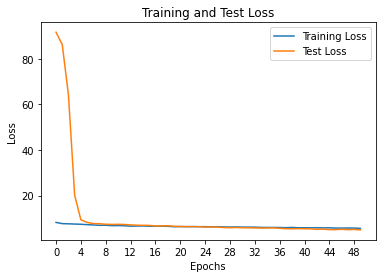

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('/content/drive/MyDrive/ML/train_loss_EfficientNetB2.pkl', 'rb'))
test_loss = load(open('/content/drive/MyDrive/ML/test_loss_EfficientNetB2.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
test_values = test_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(50)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 50, 4))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filename =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "EfficientNetB2_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filename)

model.save_weights(filename)

/content/drive/MyDrive/Colab Notebooks/20230315-183833EfficientNetB2_simclr.h5


#Classifier with frozen Encoder

In [ ]:
new_model = get_resnet_simclr(512, 256, 128)
new_model.load_weights("/content/drive/MyDrive/Colab Notebooks/20230315-183833EfficientNetB2_simclr.h5")

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
def Classifier_Network():
    '''For stage 2, simply a softmax on top of the Encoder.
    '''
    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(64, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(num_classes, activation="softmax")(features)

    classifier_model = Model(contrast_model.inputs, outputs)

    return classifier_model

In [ ]:
classifier = Classifier_Network()

In [ ]:
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
sample_weight = tf.random.uniform((tf.shape(y_train)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
sample_weight

<tf.Tensor: shape=(8529, 1), dtype=float32, numpy=
array([[0.7861433 ],
       [0.49920297],
       [0.29927063],
       ...,
       [0.05716491],
       [0.14451802],
       [0.6533736 ]], dtype=float32)>

In [ ]:
@tf.function
# train step for the 2nd stage
def train_step(x, y,sample_weight):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds,sample_weight = sample_weight)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(gradients,
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [ ]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training
train_loss_dict_classifier = {}
test_loss_dict_classifier = {}
train_acc_dict = {}
test_acc_dict = {}

for epoch in range(220):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()


    for x, y in tqdm(train_ds2):
        #print(x.shape,y.shape)
        sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
        train_step(x, y,sample_weight)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))
    train_loss_dict_classifier[epoch] = train_loss.result().numpy()
    test_loss_dict_classifier[epoch] = test_loss.result().numpy()
    train_acc_dict[epoch] = train_acc.result().numpy()*100
    test_acc_dict[epoch] = test_acc.result().numpy()*100

100%|██████████| 134/134 [00:46<00:00,  2.89it/s]


Epoch 1, Train Loss: 1.5642186403274536, Train Acc: 4.502286434173584, Test Loss: 3.1322543621063232, Test Acc: 3.469292163848877


100%|██████████| 134/134 [00:20<00:00,  6.67it/s]


Epoch 2, Train Loss: 1.5585951805114746, Train Acc: 5.569234371185303, Test Loss: 3.110503911972046, Test Acc: 4.313173770904541


100%|██████████| 134/134 [00:20<00:00,  6.63it/s]


Epoch 3, Train Loss: 1.5479212999343872, Train Acc: 6.917574882507324, Test Loss: 3.088301420211792, Test Acc: 7.688701152801514


100%|██████████| 134/134 [00:20<00:00,  6.58it/s]


Epoch 4, Train Loss: 1.544885516166687, Train Acc: 8.816977500915527, Test Loss: 3.0655252933502197, Test Acc: 18.565401077270508


100%|██████████| 134/134 [00:20<00:00,  6.58it/s]


Epoch 5, Train Loss: 1.5167901515960693, Train Acc: 10.681204795837402, Test Loss: 3.042109966278076, Test Acc: 21.42522430419922


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 6, Train Loss: 1.5118844509124756, Train Acc: 12.68613052368164, Test Loss: 3.019868850708008, Test Acc: 25.363338470458984


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 7, Train Loss: 1.4993129968643188, Train Acc: 14.468283653259277, Test Loss: 2.9923617839813232, Test Acc: 28.8795108795166


100%|██████████| 134/134 [00:20<00:00,  6.39it/s]


Epoch 8, Train Loss: 1.494251012802124, Train Acc: 16.355960845947266, Test Loss: 2.9661052227020264, Test Acc: 33.42709732055664


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 9, Train Loss: 1.474853515625, Train Acc: 18.583656311035156, Test Loss: 2.935790538787842, Test Acc: 37.45897674560547


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 10, Train Loss: 1.48104989528656, Train Acc: 19.568531036376953, Test Loss: 2.905515670776367, Test Acc: 40.17815399169922


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 11, Train Loss: 1.4453728199005127, Train Acc: 20.998945236206055, Test Loss: 2.8753538131713867, Test Acc: 42.194091796875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 12, Train Loss: 1.4467436075210571, Train Acc: 22.230037689208984, Test Loss: 2.843804121017456, Test Acc: 42.8973274230957


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 13, Train Loss: 1.4312310218811035, Train Acc: 22.839723587036133, Test Loss: 2.8126721382141113, Test Acc: 43.178619384765625


100%|██████████| 134/134 [00:20<00:00,  6.56it/s]


Epoch 14, Train Loss: 1.4229520559310913, Train Acc: 23.765975952148438, Test Loss: 2.7813398838043213, Test Acc: 43.0379753112793


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 15, Train Loss: 1.4138847589492798, Train Acc: 24.797748565673828, Test Loss: 2.7455811500549316, Test Acc: 43.45991516113281


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 16, Train Loss: 1.3763010501861572, Train Acc: 26.087465286254883, Test Loss: 2.7139759063720703, Test Acc: 43.41303253173828


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 17, Train Loss: 1.3756093978881836, Train Acc: 26.544729232788086, Test Loss: 2.6788110733032227, Test Acc: 43.78809356689453


100%|██████████| 134/134 [00:20<00:00,  6.42it/s]


Epoch 18, Train Loss: 1.3602019548416138, Train Acc: 26.556453704833984, Test Loss: 2.6486523151397705, Test Acc: 44.06938552856445


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 19, Train Loss: 1.347650408744812, Train Acc: 27.588228225708008, Test Loss: 2.6172056198120117, Test Acc: 44.4444465637207


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 20, Train Loss: 1.3336200714111328, Train Acc: 28.73724937438965, Test Loss: 2.582993745803833, Test Acc: 45.10079574584961


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 21, Train Loss: 1.3078193664550781, Train Acc: 28.877946853637695, Test Loss: 2.55171799659729, Test Acc: 45.99156188964844


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 22, Train Loss: 1.3115477561950684, Train Acc: 29.722124099731445, Test Loss: 2.5213019847869873, Test Acc: 46.97608947753906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 23, Train Loss: 1.3011542558670044, Train Acc: 30.261459350585938, Test Loss: 2.49094295501709, Test Acc: 47.81997299194336


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 24, Train Loss: 1.2761772871017456, Train Acc: 31.0001163482666, Test Loss: 2.459231376647949, Test Acc: 48.5232048034668


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 25, Train Loss: 1.2680519819259644, Train Acc: 31.785673141479492, Test Loss: 2.433175563812256, Test Acc: 49.413970947265625


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 26, Train Loss: 1.2424408197402954, Train Acc: 32.31328582763672, Test Loss: 2.40427827835083, Test Acc: 50.67979049682617


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 27, Train Loss: 1.2571011781692505, Train Acc: 33.01676559448242, Test Loss: 2.373676300048828, Test Acc: 50.961090087890625


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 28, Train Loss: 1.2275669574737549, Train Acc: 33.75542068481445, Test Loss: 2.344634771347046, Test Acc: 51.89873504638672


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 29, Train Loss: 1.2161674499511719, Train Acc: 34.90444564819336, Test Loss: 2.3200838565826416, Test Acc: 52.086265563964844


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 30, Train Loss: 1.211408019065857, Train Acc: 35.291358947753906, Test Loss: 2.2983274459838867, Test Acc: 52.4144401550293


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 31, Train Loss: 1.184450626373291, Train Acc: 36.31140899658203, Test Loss: 2.267155170440674, Test Acc: 52.883262634277344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 32, Train Loss: 1.2013202905654907, Train Acc: 36.33485794067383, Test Loss: 2.242952346801758, Test Acc: 53.11767578125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 33, Train Loss: 1.1683390140533447, Train Acc: 37.70664978027344, Test Loss: 2.216860055923462, Test Acc: 53.44585037231445


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 34, Train Loss: 1.1606112718582153, Train Acc: 37.65974807739258, Test Loss: 2.1908164024353027, Test Acc: 53.49272918701172


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 35, Train Loss: 1.1595726013183594, Train Acc: 37.730098724365234, Test Loss: 2.1672186851501465, Test Acc: 53.49272918701172


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 36, Train Loss: 1.1506115198135376, Train Acc: 38.56254959106445, Test Loss: 2.142346143722534, Test Acc: 53.58649444580078


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 37, Train Loss: 1.1313633918762207, Train Acc: 39.54742431640625, Test Loss: 2.1200265884399414, Test Acc: 53.68026351928711


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 38, Train Loss: 1.1282672882080078, Train Acc: 39.74674606323242, Test Loss: 2.102576971054077, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 39, Train Loss: 1.1247810125350952, Train Acc: 40.91921615600586, Test Loss: 2.074889659881592, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 40, Train Loss: 1.0955636501312256, Train Acc: 40.53230285644531, Test Loss: 2.0544016361236572, Test Acc: 53.82090759277344


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 41, Train Loss: 1.0942753553390503, Train Acc: 41.73994827270508, Test Loss: 2.023470878601074, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 42, Train Loss: 1.08951735496521, Train Acc: 41.165435791015625, Test Loss: 2.0007686614990234, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 43, Train Loss: 1.0912857055664062, Train Acc: 41.786842346191406, Test Loss: 1.9816787242889404, Test Acc: 53.727142333984375


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 44, Train Loss: 1.0800584554672241, Train Acc: 42.619300842285156, Test Loss: 1.9626355171203613, Test Acc: 53.727142333984375


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 45, Train Loss: 1.0706487894058228, Train Acc: 43.639347076416016, Test Loss: 1.9443397521972656, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 46, Train Loss: 1.058272123336792, Train Acc: 43.47520065307617, Test Loss: 1.9263689517974854, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 47, Train Loss: 1.047415852546692, Train Acc: 43.0531120300293, Test Loss: 1.9009371995925903, Test Acc: 53.82090759277344


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 48, Train Loss: 1.0502902269363403, Train Acc: 43.932464599609375, Test Loss: 1.8810911178588867, Test Acc: 53.82090759277344


100%|██████████| 134/134 [00:20<00:00,  6.42it/s]


Epoch 49, Train Loss: 1.0218850374221802, Train Acc: 43.66279983520508, Test Loss: 1.8630716800689697, Test Acc: 53.82090759277344


100%|██████████| 134/134 [00:20<00:00,  6.51it/s]


Epoch 50, Train Loss: 1.0194183588027954, Train Acc: 44.647674560546875, Test Loss: 1.848008394241333, Test Acc: 53.727142333984375


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 51, Train Loss: 1.0319591760635376, Train Acc: 45.32770538330078, Test Loss: 1.8241071701049805, Test Acc: 53.68026351928711


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 52, Train Loss: 0.9933460354804993, Train Acc: 44.75319290161133, Test Loss: 1.8110371828079224, Test Acc: 53.727142333984375


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 53, Train Loss: 0.996412456035614, Train Acc: 45.14011001586914, Test Loss: 1.7878507375717163, Test Acc: 53.77402877807617


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 54, Train Loss: 0.9950839281082153, Train Acc: 46.06636047363281, Test Loss: 1.7741144895553589, Test Acc: 53.867794036865234


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 55, Train Loss: 0.9845007061958313, Train Acc: 45.79669189453125, Test Loss: 1.7577766180038452, Test Acc: 53.9146728515625


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 56, Train Loss: 0.9883698225021362, Train Acc: 46.42982864379883, Test Loss: 1.74504816532135, Test Acc: 54.055320739746094


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 57, Train Loss: 0.9688143134117126, Train Acc: 46.347755432128906, Test Loss: 1.7308841943740845, Test Acc: 54.149085998535156


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 58, Train Loss: 0.9768913388252258, Train Acc: 46.47672653198242, Test Loss: 1.720859169960022, Test Acc: 54.336612701416016


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 59, Train Loss: 0.9638245105743408, Train Acc: 46.79329299926758, Test Loss: 1.6882154941558838, Test Acc: 54.43037796020508


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 60, Train Loss: 0.9549094438552856, Train Acc: 47.09813690185547, Test Loss: 1.6840862035751343, Test Acc: 54.52414321899414


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 61, Train Loss: 0.9497420191764832, Train Acc: 47.06296157836914, Test Loss: 1.6701196432113647, Test Acc: 54.52414321899414


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 62, Train Loss: 0.9477498531341553, Train Acc: 47.227108001708984, Test Loss: 1.6511623859405518, Test Acc: 54.57102584838867


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 63, Train Loss: 0.9402155876159668, Train Acc: 47.49677658081055, Test Loss: 1.6329330205917358, Test Acc: 54.664791107177734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 64, Train Loss: 0.9412440657615662, Train Acc: 46.92226791381836, Test Loss: 1.6266652345657349, Test Acc: 54.664791107177734


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 65, Train Loss: 0.9344158172607422, Train Acc: 47.68437194824219, Test Loss: 1.6165510416030884, Test Acc: 54.80543899536133


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 66, Train Loss: 0.9114830493927002, Train Acc: 48.69269561767578, Test Loss: 1.593548059463501, Test Acc: 55.13361740112305


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 67, Train Loss: 0.9011585116386414, Train Acc: 48.03611373901367, Test Loss: 1.588017463684082, Test Acc: 55.13361740112305


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 68, Train Loss: 0.9157350659370422, Train Acc: 48.23543167114258, Test Loss: 1.566157341003418, Test Acc: 55.274261474609375


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 69, Train Loss: 0.9014157652854919, Train Acc: 48.751319885253906, Test Loss: 1.566998839378357, Test Acc: 55.321144104003906


100%|██████████| 134/134 [00:20<00:00,  6.40it/s]


Epoch 70, Train Loss: 0.8954254388809204, Train Acc: 48.751319885253906, Test Loss: 1.5555957555770874, Test Acc: 55.74308776855469


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 71, Train Loss: 0.8859643340110779, Train Acc: 48.786495208740234, Test Loss: 1.5352177619934082, Test Acc: 55.78996658325195


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 72, Train Loss: 0.8911691904067993, Train Acc: 48.845115661621094, Test Loss: 1.5316226482391357, Test Acc: 55.88372802734375


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 73, Train Loss: 0.8864955306053162, Train Acc: 48.76304244995117, Test Loss: 1.5168676376342773, Test Acc: 56.02437973022461


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 74, Train Loss: 0.8773614168167114, Train Acc: 49.31410598754883, Test Loss: 1.5064384937286377, Test Acc: 56.30567169189453


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 75, Train Loss: 0.8880895376205444, Train Acc: 49.24375534057617, Test Loss: 1.4929101467132568, Test Acc: 56.35255432128906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 76, Train Loss: 0.8776147961616516, Train Acc: 49.68929672241211, Test Loss: 1.497890591621399, Test Acc: 56.446319580078125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 77, Train Loss: 0.8608543872833252, Train Acc: 49.10306167602539, Test Loss: 1.4803327322006226, Test Acc: 56.54008483886719


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 78, Train Loss: 0.8615588545799255, Train Acc: 49.595497131347656, Test Loss: 1.4716473817825317, Test Acc: 56.68073272705078


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 79, Train Loss: 0.8521791696548462, Train Acc: 50.33415603637695, Test Loss: 1.470179557800293, Test Acc: 56.82137680053711


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 80, Train Loss: 0.8677819967269897, Train Acc: 49.54859924316406, Test Loss: 1.4522103071212769, Test Acc: 56.82137680053711


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 81, Train Loss: 0.8534188270568848, Train Acc: 50.00586700439453, Test Loss: 1.436800479888916, Test Acc: 56.774497985839844


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 82, Train Loss: 0.8616086840629578, Train Acc: 49.829994201660156, Test Loss: 1.4482078552246094, Test Acc: 56.9620246887207


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 83, Train Loss: 0.8474443554878235, Train Acc: 50.52174758911133, Test Loss: 1.4343198537826538, Test Acc: 57.29020309448242


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 84, Train Loss: 0.8349471092224121, Train Acc: 50.041038513183594, Test Loss: 1.418889045715332, Test Acc: 57.1026725769043


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 85, Train Loss: 0.8472740650177002, Train Acc: 49.90034103393555, Test Loss: 1.4222551584243774, Test Acc: 57.33708190917969


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 86, Train Loss: 0.8504961133003235, Train Acc: 50.17000961303711, Test Loss: 1.4058005809783936, Test Acc: 57.33708190917969


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 87, Train Loss: 0.82925945520401, Train Acc: 50.39277648925781, Test Loss: 1.4016656875610352, Test Acc: 57.7590217590332


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 88, Train Loss: 0.8345649838447571, Train Acc: 50.38105392456055, Test Loss: 1.4026881456375122, Test Acc: 57.430850982666016


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 89, Train Loss: 0.8424513936042786, Train Acc: 49.90034103393555, Test Loss: 1.3816578388214111, Test Acc: 57.430850982666016


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 90, Train Loss: 0.8375931978225708, Train Acc: 50.81486511230469, Test Loss: 1.3794734477996826, Test Acc: 57.47772979736328


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 91, Train Loss: 0.8267751336097717, Train Acc: 50.46312713623047, Test Loss: 1.3696058988571167, Test Acc: 57.47772979736328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 92, Train Loss: 0.8196015357971191, Train Acc: 51.260406494140625, Test Loss: 1.3798660039901733, Test Acc: 57.571495056152344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 93, Train Loss: 0.8169564604759216, Train Acc: 50.908668518066406, Test Loss: 1.3642224073410034, Test Acc: 57.665260314941406


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 94, Train Loss: 0.8045491576194763, Train Acc: 50.88521194458008, Test Loss: 1.3547048568725586, Test Acc: 57.665260314941406


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 95, Train Loss: 0.8147884011268616, Train Acc: 50.86176300048828, Test Loss: 1.345568060874939, Test Acc: 57.71214294433594


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 96, Train Loss: 0.8103969097137451, Train Acc: 51.03763198852539, Test Loss: 1.3412847518920898, Test Acc: 57.52461624145508


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 97, Train Loss: 0.7939346432685852, Train Acc: 50.955562591552734, Test Loss: 1.3430871963500977, Test Acc: 57.7590217590332


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 98, Train Loss: 0.7930686473846436, Train Acc: 50.93211364746094, Test Loss: 1.335524559020996, Test Acc: 58.227848052978516


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 99, Train Loss: 0.7964211702346802, Train Acc: 51.11970901489258, Test Loss: 1.3276466131210327, Test Acc: 58.13408660888672


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 100, Train Loss: 0.7997469305992126, Train Acc: 50.967288970947266, Test Loss: 1.3167120218276978, Test Acc: 57.946556091308594


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 101, Train Loss: 0.7969248294830322, Train Acc: 51.30730438232422, Test Loss: 1.322939157485962, Test Acc: 58.040321350097656


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 102, Train Loss: 0.7931067943572998, Train Acc: 51.27212905883789, Test Loss: 1.318867564201355, Test Acc: 58.040321350097656


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 103, Train Loss: 0.790359616279602, Train Acc: 51.45972442626953, Test Loss: 1.3032253980636597, Test Acc: 57.89967346191406


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 104, Train Loss: 0.7862656712532043, Train Acc: 52.56184768676758, Test Loss: 1.3057684898376465, Test Acc: 57.852787017822266


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 105, Train Loss: 0.7781150341033936, Train Acc: 51.74111557006836, Test Loss: 1.2969942092895508, Test Acc: 57.89967346191406


100%|██████████| 134/134 [00:20<00:00,  6.52it/s]


Epoch 106, Train Loss: 0.7705267071723938, Train Acc: 51.50662612915039, Test Loss: 1.2937922477722168, Test Acc: 57.89967346191406


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 107, Train Loss: 0.7912834286689758, Train Acc: 51.881813049316406, Test Loss: 1.289691686630249, Test Acc: 57.89967346191406


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 108, Train Loss: 0.7700369954109192, Train Acc: 51.881813049316406, Test Loss: 1.2892372608184814, Test Acc: 57.99343490600586


100%|██████████| 134/134 [00:20<00:00,  6.42it/s]


Epoch 109, Train Loss: 0.7703052759170532, Train Acc: 52.33907699584961, Test Loss: 1.276965618133545, Test Acc: 58.040321350097656


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 110, Train Loss: 0.7710649371147156, Train Acc: 52.04595947265625, Test Loss: 1.2716610431671143, Test Acc: 58.08720016479492


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 111, Train Loss: 0.7765023112297058, Train Acc: 51.58869552612305, Test Loss: 1.27839994430542, Test Acc: 58.040321350097656


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 112, Train Loss: 0.7796698808670044, Train Acc: 51.87009048461914, Test Loss: 1.2667498588562012, Test Acc: 58.27472686767578


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 113, Train Loss: 0.7545398473739624, Train Acc: 51.788021087646484, Test Loss: 1.2628520727157593, Test Acc: 58.368492126464844


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 114, Train Loss: 0.7605329155921936, Train Acc: 51.69422149658203, Test Loss: 1.26740300655365, Test Acc: 58.46226119995117


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 115, Train Loss: 0.7684028744697571, Train Acc: 52.890140533447266, Test Loss: 1.2541300058364868, Test Acc: 58.368492126464844


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 116, Train Loss: 0.7679320573806763, Train Acc: 52.25700759887695, Test Loss: 1.2486530542373657, Test Acc: 58.50914001464844


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 117, Train Loss: 0.7627188563346863, Train Acc: 52.30390548706055, Test Loss: 1.2477540969848633, Test Acc: 58.6029052734375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 118, Train Loss: 0.7598873376846313, Train Acc: 52.81978988647461, Test Loss: 1.2488479614257812, Test Acc: 58.69667053222656


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 119, Train Loss: 0.7595272660255432, Train Acc: 51.58869552612305, Test Loss: 1.2571640014648438, Test Acc: 58.46226119995117


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 120, Train Loss: 0.7589317560195923, Train Acc: 52.116310119628906, Test Loss: 1.2354601621627808, Test Acc: 58.69667053222656


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 121, Train Loss: 0.7556375861167908, Train Acc: 52.50322341918945, Test Loss: 1.2323391437530518, Test Acc: 58.368492126464844


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 122, Train Loss: 0.7437628507614136, Train Acc: 52.468048095703125, Test Loss: 1.2301599979400635, Test Acc: 58.79043197631836


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 123, Train Loss: 0.7643815875053406, Train Acc: 52.362525939941406, Test Loss: 1.2349662780761719, Test Acc: 58.50914001464844


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 124, Train Loss: 0.7432433366775513, Train Acc: 52.10458755493164, Test Loss: 1.2235770225524902, Test Acc: 58.556026458740234


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 125, Train Loss: 0.7454419136047363, Train Acc: 52.444602966308594, Test Loss: 1.2306967973709106, Test Acc: 58.46226119995117


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 126, Train Loss: 0.7534008026123047, Train Acc: 51.97561264038086, Test Loss: 1.224097490310669, Test Acc: 58.743553161621094


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 127, Train Loss: 0.7474762201309204, Train Acc: 52.15148162841797, Test Loss: 1.2149766683578491, Test Acc: 58.6497917175293


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 128, Train Loss: 0.7481793165206909, Train Acc: 52.597023010253906, Test Loss: 1.210202932357788, Test Acc: 58.837318420410156


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 129, Train Loss: 0.7589086294174194, Train Acc: 52.63219451904297, Test Loss: 1.2140552997589111, Test Acc: 58.88420486450195


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 130, Train Loss: 0.7443617582321167, Train Acc: 52.66736602783203, Test Loss: 1.2100307941436768, Test Acc: 58.88420486450195


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 131, Train Loss: 0.7477217316627502, Train Acc: 52.995662689208984, Test Loss: 1.2124232053756714, Test Acc: 58.88420486450195


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 132, Train Loss: 0.7453556060791016, Train Acc: 53.11290740966797, Test Loss: 1.205078125, Test Acc: 58.93108367919922


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 133, Train Loss: 0.7390557527542114, Train Acc: 53.370849609375, Test Loss: 1.1967052221298218, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 134, Train Loss: 0.7401671409606934, Train Acc: 52.66736602783203, Test Loss: 1.1973011493682861, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 135, Train Loss: 0.7397298216819763, Train Acc: 52.63219451904297, Test Loss: 1.1950892210006714, Test Acc: 58.97796630859375


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 136, Train Loss: 0.7401360273361206, Train Acc: 52.80806350708008, Test Loss: 1.1984602212905884, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 137, Train Loss: 0.7325860261917114, Train Acc: 53.300506591796875, Test Loss: 1.2001540660858154, Test Acc: 59.11861038208008


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 138, Train Loss: 0.7213841080665588, Train Acc: 53.21842956542969, Test Loss: 1.1981981992721558, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:20<00:00,  6.42it/s]


Epoch 139, Train Loss: 0.7340211272239685, Train Acc: 53.546722412109375, Test Loss: 1.1828501224517822, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 140, Train Loss: 0.7384123206138611, Train Acc: 52.98394012451172, Test Loss: 1.1913706064224243, Test Acc: 59.024845123291016


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 141, Train Loss: 0.7233461737632751, Train Acc: 52.6439208984375, Test Loss: 1.1869914531707764, Test Acc: 58.93108367919922


100%|██████████| 134/134 [00:20<00:00,  6.42it/s]


Epoch 142, Train Loss: 0.7301921248435974, Train Acc: 53.534996032714844, Test Loss: 1.177443027496338, Test Acc: 59.11861038208008


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 143, Train Loss: 0.7106952667236328, Train Acc: 53.124637603759766, Test Loss: 1.1745688915252686, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 144, Train Loss: 0.7203574776649475, Train Acc: 53.241878509521484, Test Loss: 1.1757298707962036, Test Acc: 59.11861038208008


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 145, Train Loss: 0.7273970246315002, Train Acc: 53.3942985534668, Test Loss: 1.1778309345245361, Test Acc: 59.353023529052734


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 146, Train Loss: 0.7173754572868347, Train Acc: 52.80806350708008, Test Loss: 1.1877942085266113, Test Acc: 59.39990997314453


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 147, Train Loss: 0.7162317633628845, Train Acc: 53.370849609375, Test Loss: 1.1736040115356445, Test Acc: 59.353023529052734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 148, Train Loss: 0.7204858660697937, Train Acc: 53.07773208618164, Test Loss: 1.1804372072219849, Test Acc: 59.30613708496094


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 149, Train Loss: 0.7115088105201721, Train Acc: 53.49982452392578, Test Loss: 1.1798404455184937, Test Acc: 59.21237564086914


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 150, Train Loss: 0.71925288438797, Train Acc: 53.26532745361328, Test Loss: 1.1653281450271606, Test Acc: 59.25925827026367


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 151, Train Loss: 0.7217714190483093, Train Acc: 53.42947769165039, Test Loss: 1.1696432828903198, Test Acc: 59.11861038208008


100%|██████████| 134/134 [00:20<00:00,  6.52it/s]


Epoch 152, Train Loss: 0.7017411589622498, Train Acc: 53.839839935302734, Test Loss: 1.163261890411377, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 153, Train Loss: 0.7141714692115784, Train Acc: 53.67569351196289, Test Loss: 1.1599317789077759, Test Acc: 59.21237564086914


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 154, Train Loss: 0.7157502174377441, Train Acc: 53.171531677246094, Test Loss: 1.163208246231079, Test Acc: 59.21237564086914


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 155, Train Loss: 0.7156673073768616, Train Acc: 53.300506591796875, Test Loss: 1.1629133224487305, Test Acc: 59.165496826171875


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 156, Train Loss: 0.718105137348175, Train Acc: 53.03083801269531, Test Loss: 1.1667309999465942, Test Acc: 59.165496826171875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 157, Train Loss: 0.7042490243911743, Train Acc: 53.74604415893555, Test Loss: 1.1560803651809692, Test Acc: 59.07173156738281


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 158, Train Loss: 0.7151588201522827, Train Acc: 53.886741638183594, Test Loss: 1.1558434963226318, Test Acc: 59.165496826171875


100%|██████████| 134/134 [00:20<00:00,  6.40it/s]


Epoch 159, Train Loss: 0.7125270962715149, Train Acc: 53.71086502075195, Test Loss: 1.1463582515716553, Test Acc: 59.25925827026367


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 160, Train Loss: 0.7087590098381042, Train Acc: 53.8281135559082, Test Loss: 1.1524204015731812, Test Acc: 59.21237564086914


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 161, Train Loss: 0.6995798945426941, Train Acc: 54.508148193359375, Test Loss: 1.158005714416504, Test Acc: 59.165496826171875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 162, Train Loss: 0.6932740807533264, Train Acc: 54.039161682128906, Test Loss: 1.1469565629959106, Test Acc: 59.25925827026367


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 163, Train Loss: 0.706661581993103, Train Acc: 53.359127044677734, Test Loss: 1.1473618745803833, Test Acc: 59.165496826171875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 164, Train Loss: 0.7083988785743713, Train Acc: 54.12123107910156, Test Loss: 1.1413633823394775, Test Acc: 59.353023529052734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 165, Train Loss: 0.7002657651901245, Train Acc: 53.27705764770508, Test Loss: 1.1482775211334229, Test Acc: 59.21237564086914


100%|██████████| 134/134 [00:20<00:00,  6.44it/s]


Epoch 166, Train Loss: 0.7034865617752075, Train Acc: 54.132957458496094, Test Loss: 1.1432826519012451, Test Acc: 59.30613708496094


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 167, Train Loss: 0.6944546103477478, Train Acc: 54.1095085144043, Test Loss: 1.1390876770019531, Test Acc: 59.353023529052734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 168, Train Loss: 0.704503059387207, Train Acc: 53.89846420288086, Test Loss: 1.1370093822479248, Test Acc: 59.540550231933594


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 169, Train Loss: 0.6874974370002747, Train Acc: 53.93363952636719, Test Loss: 1.1390764713287354, Test Acc: 59.540550231933594


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 170, Train Loss: 0.6927183270454407, Train Acc: 54.15640640258789, Test Loss: 1.1397193670272827, Test Acc: 59.49367141723633


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 171, Train Loss: 0.7020611763000488, Train Acc: 53.69914245605469, Test Loss: 1.1370618343353271, Test Acc: 59.58743667602539


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 172, Train Loss: 0.7072651386260986, Train Acc: 53.980533599853516, Test Loss: 1.1317529678344727, Test Acc: 59.58743667602539


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 173, Train Loss: 0.6937222480773926, Train Acc: 53.74604415893555, Test Loss: 1.1325631141662598, Test Acc: 59.58743667602539


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 174, Train Loss: 0.7032399773597717, Train Acc: 54.0860595703125, Test Loss: 1.1410778760910034, Test Acc: 59.58743667602539


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 175, Train Loss: 0.6858906745910645, Train Acc: 53.99225997924805, Test Loss: 1.1362172365188599, Test Acc: 59.634315490722656


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 176, Train Loss: 0.6906776428222656, Train Acc: 54.19158172607422, Test Loss: 1.1348412036895752, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.57it/s]


Epoch 177, Train Loss: 0.7016677260398865, Train Acc: 53.687416076660156, Test Loss: 1.1310094594955444, Test Acc: 59.82184982299805


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 178, Train Loss: 0.6917564868927002, Train Acc: 54.367454528808594, Test Loss: 1.1266902685165405, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 179, Train Loss: 0.6938072443008423, Train Acc: 53.99225997924805, Test Loss: 1.1348463296890259, Test Acc: 59.72808074951172


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 180, Train Loss: 0.6919018626213074, Train Acc: 54.3088264465332, Test Loss: 1.122801661491394, Test Acc: 59.72808074951172


100%|██████████| 134/134 [00:20<00:00,  6.53it/s]


Epoch 181, Train Loss: 0.6872202157974243, Train Acc: 54.44952392578125, Test Loss: 1.1344318389892578, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 182, Train Loss: 0.6959074139595032, Train Acc: 54.7778205871582, Test Loss: 1.1235989332199097, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 183, Train Loss: 0.6829739809036255, Train Acc: 54.02743911743164, Test Loss: 1.127395510673523, Test Acc: 59.72808074951172


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 184, Train Loss: 0.6983099579811096, Train Acc: 54.26192855834961, Test Loss: 1.126799464225769, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.53it/s]


Epoch 185, Train Loss: 0.693494975566864, Train Acc: 53.980533599853516, Test Loss: 1.117502212524414, Test Acc: 59.68120193481445


100%|██████████| 134/134 [00:20<00:00,  6.53it/s]


Epoch 186, Train Loss: 0.6817263960838318, Train Acc: 53.74604415893555, Test Loss: 1.128212332725525, Test Acc: 59.72808074951172


100%|██████████| 134/134 [00:20<00:00,  6.53it/s]


Epoch 187, Train Loss: 0.6880632042884827, Train Acc: 54.332279205322266, Test Loss: 1.1171128749847412, Test Acc: 59.82184982299805


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 188, Train Loss: 0.6811046600341797, Train Acc: 53.886741638183594, Test Loss: 1.1208815574645996, Test Acc: 59.82184982299805


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 189, Train Loss: 0.6899394989013672, Train Acc: 54.250205993652344, Test Loss: 1.112027883529663, Test Acc: 59.962493896484375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 190, Train Loss: 0.682994544506073, Train Acc: 54.35572814941406, Test Loss: 1.1140154600143433, Test Acc: 60.009376525878906


100%|██████████| 134/134 [00:20<00:00,  6.42it/s]


Epoch 191, Train Loss: 0.6842974424362183, Train Acc: 54.5433235168457, Test Loss: 1.1114205121994019, Test Acc: 60.009376525878906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 192, Train Loss: 0.7041164636611938, Train Acc: 54.29710006713867, Test Loss: 1.1200979948043823, Test Acc: 59.962493896484375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 193, Train Loss: 0.6844002604484558, Train Acc: 54.5667724609375, Test Loss: 1.1115580797195435, Test Acc: 59.962493896484375


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 194, Train Loss: 0.6812967658042908, Train Acc: 54.039161682128906, Test Loss: 1.1117511987686157, Test Acc: 59.962493896484375


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 195, Train Loss: 0.6789284348487854, Train Acc: 54.05088806152344, Test Loss: 1.1127002239227295, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 196, Train Loss: 0.6853530406951904, Train Acc: 54.215030670166016, Test Loss: 1.1153990030288696, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 197, Train Loss: 0.6756274700164795, Train Acc: 54.55504608154297, Test Loss: 1.1108343601226807, Test Acc: 60.009376525878906


100%|██████████| 134/134 [00:20<00:00,  6.45it/s]


Epoch 198, Train Loss: 0.6847366690635681, Train Acc: 54.66057205200195, Test Loss: 1.113255500793457, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 199, Train Loss: 0.6824244260787964, Train Acc: 54.41434860229492, Test Loss: 1.1067109107971191, Test Acc: 60.009376525878906


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 200, Train Loss: 0.674464762210846, Train Acc: 54.390899658203125, Test Loss: 1.1165598630905151, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 201, Train Loss: 0.6749184727668762, Train Acc: 54.84816360473633, Test Loss: 1.1055989265441895, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 202, Train Loss: 0.6719431281089783, Train Acc: 54.250205993652344, Test Loss: 1.1088558435440063, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:20<00:00,  6.41it/s]


Epoch 203, Train Loss: 0.6868287920951843, Train Acc: 53.921913146972656, Test Loss: 1.1064229011535645, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 204, Train Loss: 0.6880690455436707, Train Acc: 54.332279205322266, Test Loss: 1.1085125207901, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:20<00:00,  6.50it/s]


Epoch 205, Train Loss: 0.672592043876648, Train Acc: 54.02743911743164, Test Loss: 1.1072322130203247, Test Acc: 60.05625915527344


100%|██████████| 134/134 [00:20<00:00,  6.46it/s]


Epoch 206, Train Loss: 0.6739521026611328, Train Acc: 55.809593200683594, Test Loss: 1.1074025630950928, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 207, Train Loss: 0.6736372709274292, Train Acc: 54.625396728515625, Test Loss: 1.103109359741211, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 208, Train Loss: 0.6628267168998718, Train Acc: 54.883338928222656, Test Loss: 1.099487543106079, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:20<00:00,  6.43it/s]


Epoch 209, Train Loss: 0.6736243963241577, Train Acc: 55.3171501159668, Test Loss: 1.106925368309021, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 210, Train Loss: 0.6684115529060364, Train Acc: 54.61367416381836, Test Loss: 1.0953786373138428, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 211, Train Loss: 0.6838451027870178, Train Acc: 54.1095085144043, Test Loss: 1.1016454696655273, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 212, Train Loss: 0.677082896232605, Train Acc: 55.23508071899414, Test Loss: 1.0964903831481934, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 213, Train Loss: 0.6712397336959839, Train Acc: 55.25852966308594, Test Loss: 1.0972011089324951, Test Acc: 60.19690704345703


100%|██████████| 134/134 [00:20<00:00,  6.49it/s]


Epoch 214, Train Loss: 0.6682456731796265, Train Acc: 54.484703063964844, Test Loss: 1.1047251224517822, Test Acc: 60.19690704345703


100%|██████████| 134/134 [00:20<00:00,  6.48it/s]


Epoch 215, Train Loss: 0.673247218132019, Train Acc: 54.43779754638672, Test Loss: 1.0931735038757324, Test Acc: 60.150020599365234


100%|██████████| 134/134 [00:20<00:00,  6.47it/s]


Epoch 216, Train Loss: 0.6663455963134766, Train Acc: 55.50475311279297, Test Loss: 1.1007808446884155, Test Acc: 60.150020599365234


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 217, Train Loss: 0.6710995435714722, Train Acc: 54.988861083984375, Test Loss: 1.092792272567749, Test Acc: 60.19690704345703


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 218, Train Loss: 0.6640567183494568, Train Acc: 54.871612548828125, Test Loss: 1.0985437631607056, Test Acc: 60.19690704345703


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 219, Train Loss: 0.6721863150596619, Train Acc: 55.07093811035156, Test Loss: 1.0961072444915771, Test Acc: 60.2437858581543


100%|██████████| 134/134 [00:20<00:00,  6.60it/s]


Epoch 220, Train Loss: 0.6731915473937988, Train Acc: 54.883338928222656, Test Loss: 1.0881052017211914, Test Acc: 60.19690704345703


In [ ]:

# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_2_EfficientNetB2.pkl', 'wb') as file:
    dump(train_loss_dict_classifier, file)

# Save the test loss values
with open('/content/drive/MyDrive/ML/test_loss_2_EfficientNetB2.pkl', 'wb') as file:
    dump(test_loss_dict_classifier, file)

# Save the training acc values
with open('/content/drive/MyDrive/ML/train_acc_2_EfficientNetB2.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the test acc values
with open('/content/drive/MyDrive/ML/test_acc_2_EfficientNetB2.pkl', 'wb') as file:
    dump(test_acc_dict, file)

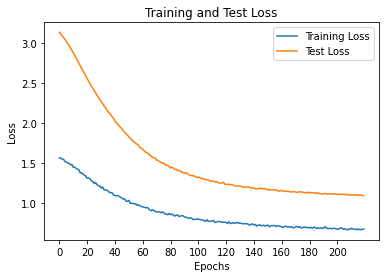

In [ ]:
# Load the training and validation loss dictionaries
train_loss_class = load(open('/content/drive/MyDrive/ML/train_loss_2_EfficientNetB2.pkl', 'rb'))
test_loss_class = load(open('/content/drive/MyDrive/ML/test_loss_2_EfficientNetB2.pkl', 'rb'))

# Retrieve each dictionary's values
train_values_class = train_loss_class.values()
test_values_class = test_loss_class.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values_class)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values_class)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

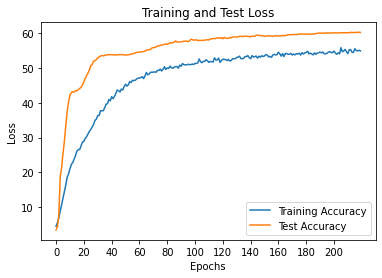

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('/content/drive/MyDrive/ML/train_acc_2_EfficientNetB2.pkl', 'rb'))
test_acc = load(open('/content/drive/MyDrive/ML/test_acc_2_EfficientNetB2.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_acc.values()
test_values = test_acc.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Accuracy')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Accuracy')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filenames =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "EfficientNetB2_accuracy_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filenames)

classifier.save_weights(filenames)

/content/drive/MyDrive/Colab Notebooks/20230323-082434EfficientNetB2_accuracy_simclr.h5


##Prediction

In [ ]:
classifier.load_weights(filenames)

In [ ]:
X = tf.reshape(x_test[50], [1, 224, 224, 3]) ##need to reshape
classifier.predict(X)

1/1 [==============================] - 3s 3s/step


array([[1.0602302e-03, 7.0440132e-05, 1.6126042e-03, 2.9580715e-05,
        8.0971775e-04, 1.3724774e-04, 6.5107283e-04, 6.7809997e-05,
        1.6768678e-03, 1.8288962e-04, 5.1410240e-04, 7.9268791e-02,
        8.4602684e-01, 5.6763239e-02, 3.7857988e-03, 2.9939739e-03,
        8.5641182e-04, 1.9991046e-03, 4.5100151e-04, 1.7333467e-04,
        1.2608214e-04, 3.8419725e-04, 3.5883117e-04]], dtype=float32)

In [ ]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)
y_predict

In [ ]:
#CONFUSIN MATRIX
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
class_names = ["cecum", "ileum", "retroflex_rectum", "hemorrhoids", "polyps","ulcerative_colitis_grade_0_1","ulcerative_colitis_grade_1","ulcerative_colitis_grade_1_2","ulcerative_colitis_grade_2","ulcerative_colitis_grade_2_3","ulcerative_colitis_grade_3","bbps_0_1" ,"bbps_2_3","impacted_stool","dyed_lifted_polyps","dyed_resection_margins","pylorus","retroflex_stomach","z_line","barretts","barretts_short_segment","esophagitis_a" ,"esophagitis_b_d"]
print(metrics.classification_report(y_test, y_predict, target_names=class_names))

                              precision    recall  f1-score   support

                       cecum       0.68      0.88      0.77       206
                       ileum       0.00      0.00      0.00         1
            retroflex_rectum       0.00      0.00      0.00        74
                 hemorrhoids       0.00      0.00      0.00         1
                      polyps       0.50      0.90      0.64       198
ulcerative_colitis_grade_0_1       0.00      0.00      0.00         6
  ulcerative_colitis_grade_1       0.00      0.00      0.00        41
ulcerative_colitis_grade_1_2       0.00      0.00      0.00         2
  ulcerative_colitis_grade_2       0.00      0.00      0.00        90
ulcerative_colitis_grade_2_3       0.00      0.00      0.00         5
  ulcerative_colitis_grade_3       0.00      0.00      0.00        18
                    bbps_0_1       0.89      0.52      0.66       138
                    bbps_2_3       0.77      0.98      0.86       237
              impac

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


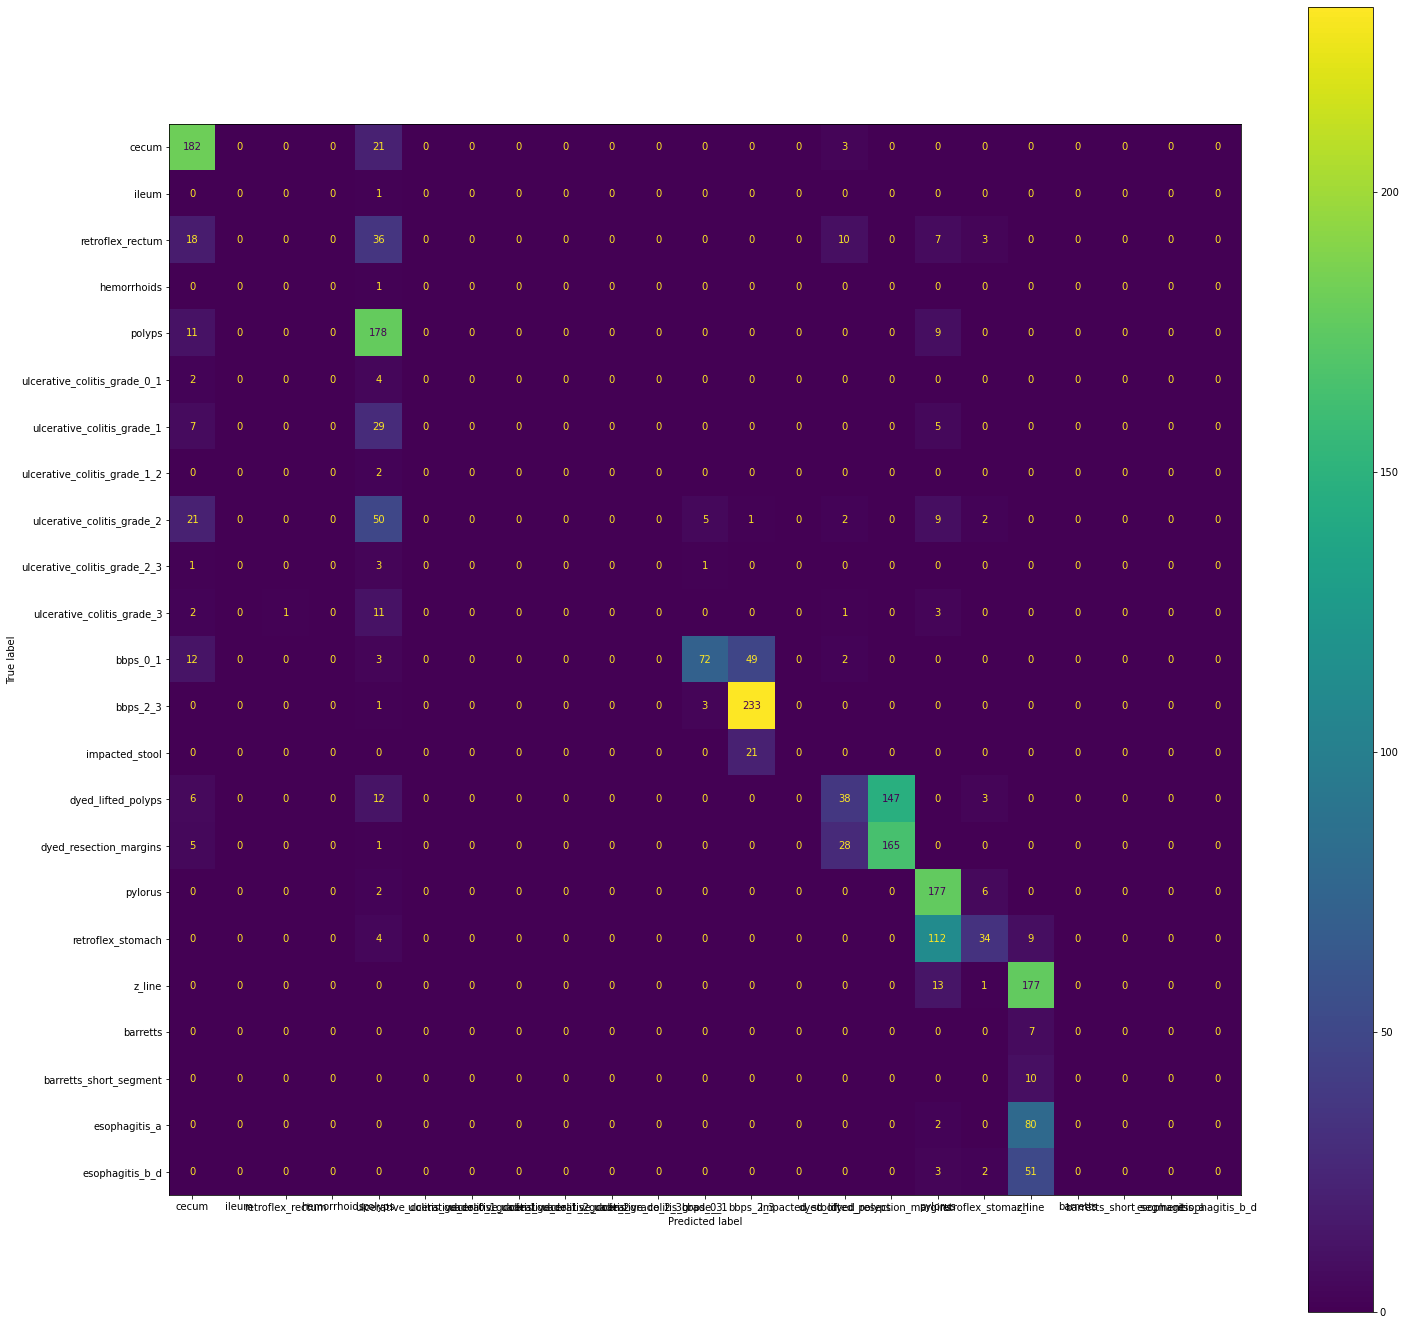

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = class_names)

plt.rcParams["figure.figsize"] = [24,24]
cm_display.plot(xticks_rotation = 'vertical')
plt.show()

In [ ]:
#check layers trainable
for i, layer in enumerate(classifier.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_2 [(None, 224, 224, 3)] False
1 rescaling_1 (None, 224, 224, 3) False
2 normalization_1 (None, 224, 224, 3) False
3 stem_conv_pad (None, 225, 225, 3) False
4 stem_conv (None, 112, 112, 32) False
5 stem_bn (None, 112, 112, 32) False
6 stem_activation (None, 112, 112, 32) False
7 block1a_dwconv (None, 112, 112, 32) False
8 block1a_bn (None, 112, 112, 32) False
9 block1a_activation (None, 112, 112, 32) False
10 block1a_se_squeeze (None, 32) False
11 block1a_se_reshape (None, 1, 1, 32) False
12 block1a_se_reduce (None, 1, 1, 8) False
13 block1a_se_expand (None, 1, 1, 32) False
14 block1a_se_excite (None, 112, 112, 32) False
15 block1a_project_conv (None, 112, 112, 16) False
16 block1a_project_bn (None, 112, 112, 16) False
17 block1b_dwconv (None, 112, 112, 16) False
18 block1b_bn (None, 112, 112, 16) False
19 block1b_activation (None, 112, 112, 16) False
20 block1b_se_squeeze (None, 16) False
21 block1b_se_reshape (None, 1, 1, 16) False
22 block1b_se_reduce (None, 1, 1, 4) False
23

#XAI

In [ ]:
##check if any error occurs here, if occurs, most likely graph not connected
def flatten_model(model):
    if not any(hasattr(layer, 'layers') for layer in model.layers):
        return model  # No sub-model defined within this model
    inputs = None
    outputs = None
    for layer in model.layers:
        if inputs is None:
            inputs = layer.input
        if hasattr(layer, 'layers'):
            submodel = layer
            last_layer = submodel.layers[-1]
            outputs = submodel.output

        if outputs is None:
            outputs = layer
        else:
            outputs = layer(outputs)
    return keras.Model(inputs=inputs, outputs=outputs)

flat_model = flatten_model(classifier)

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
X = tf.convert_to_tensor(x_test[50], dtype=tf.float32)    ##need to convert the input data to tensor
y = y_test[50].item()   ##just a single integer value, no numpy array
score = CategoricalScore(y)

In [ ]:
image_titles = ['Image']
from matplotlib import cm

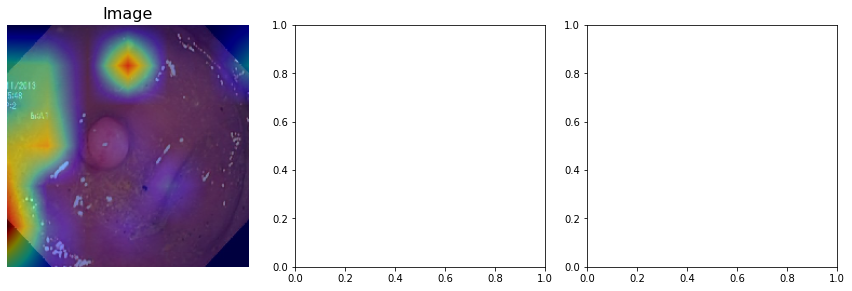

In [ ]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(classifier,
                  model_modifier=replace2linear,
                  clone=False)

grad_cam = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap1 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap1, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

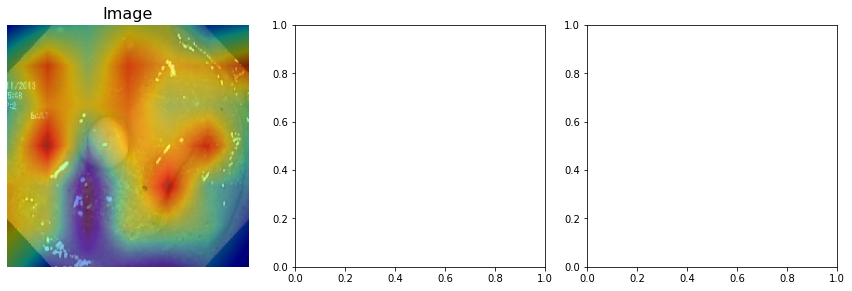

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(classifier, model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM++
grad_cam = gradcam(score, X, penultimate_layer=-1)
# Render
#for i, title in enumerate(image_titles):
#    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap2, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with ScoreCAM
grad_cam = scorecam(score, X, penultimate_layer=-1, max_N=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap3 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap3, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with Faster-ScoreCAM
grad_cam = scorecam(score,X,penultimate_layer=-1,max_N=10)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap4 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap4, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.layercam import Layercam

layercam = Layercam(classifier, model_modifier=replace2linear,clone = False)

# Generate heatmap with Faster-ScoreCAM
grad_cam = layercam(score,X,penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap5 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap5, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(classifier, model_modifier=replace2linear,clone=False)

# Generate saliency map
saliency_map_van = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap6 = np.uint8(cm.jet(saliency_map_van[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap6, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map_smooth = saliency(score,X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap7 = np.uint8(cm.jet(saliency_map_smooth[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap7, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Render
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

ax[0][0].set_title("Original", fontsize=12)
ax[0][0].imshow(x_test[50])
ax[0][0].axis('off')

ax[0][1].set_title("GradCAM", fontsize=12)
ax[0][1].imshow(x_test[50])
ax[0][1].imshow(heatmap1, cmap='jet', alpha=0.5)
ax[0][1].axis('off')

ax[0][2].set_title("GradCAM++", fontsize=12)
ax[0][2].imshow(x_test[50])
ax[0][2].imshow(heatmap2, cmap='jet', alpha=0.5)
ax[0][2].axis('off')

ax[0][3].set_title("ScoreCAM", fontsize=12)
ax[0][3].imshow(x_test[50])
ax[0][3].imshow(heatmap3, cmap='jet', alpha=0.5)
ax[0][3].axis('off')

ax[1][0].set_title("ScoreCAM++", fontsize=12)
ax[1][0].imshow(x_test[50])
ax[1][0].imshow(heatmap4, cmap='jet', alpha=0.5)
ax[1][0].axis('off')

ax[1][1].set_title("LayerCAM", fontsize=12)
ax[1][1].imshow(x_test[50])
ax[1][1].imshow(heatmap5, cmap='jet', alpha=0.5)
ax[1][1].axis('off')

ax[1][2].set_title("Vanilla Saliency", fontsize=12)
ax[1][2].imshow(saliency_map_van[0], cmap='jet')
ax[1][2].axis('off')

ax[1][3].set_title("Smooth Grad", fontsize=12)
ax[1][3].imshow(saliency_map_smooth[0], cmap='jet')
ax[1][3].axis('off')

plt.show()